# Grover's algorithm
Author: Parsa Vares


## Background

Amplitude amplification is a general purpose quantum algorithm, or subroutine, that can be used to obtain a quadratic speedup over a handful of classical algorithms. [Grover’s algorithm](https://arxiv.org/abs/quant-ph/9605043) was the first to demonstrate this speedup on unstructured search problems. Formulating a Grover's search problem requires an oracle function that marks one or more computational basis states as the states we are interested in finding, and an amplification circuit that increases the amplitude of marked states, consequently suppressing the remaining states.

Here, we demonstrate how to construct Grover oracles and use the `GroverOperator` from the Qiskit circuit library to easily set up a Grover's search instance. The runtime `Sampler` primitive allows seamless execution of Grover circuits.


### Replace the "?" by real code. Make sure the Jupyter Notebook works fine.

### Next, make these exercises:
1. Extend this Jupyter Notebook with additional Markup Comments to make the link between the Theory we covered and the Jupyter Notebook much more clear.
2. Apply the algorithm on 1 new marked state with 3 Qubits on a Real Device.
3. Run the algorithm on a Fake Device with 2 new marked states.
4. Run the algorithm on a Simulator with the same 2 marked states as in (3)
5. Apply the algorithm on 1 new marked state with 4 Qubits on a Real Device
You must do this in 1 single Jupyter Notebook, i.e. 1 file. 


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later


## Step 1. Map classical inputs to a quantum problem

Grover's algorithm requires an [oracle](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/grovers-algorithm) that specifies one or more marked computational basis states, where "marked" means a state with a phase of -1.  A controlled-Z gate, or its multi-controlled generalization over $N$ qubits, marks the $2^{N}-1$ state (`'1'`\*$N$ bit-string).  Marking basis states with one or more `'0'` in the binary representation requires applying X-gates on the corresponding qubits before and after the controlled-Z gate; equivalent to having an open-control on that qubit.  In the following code, we define an oracle that does just that, marking one or more input basis states defined through their bit-string representation.  The `MCMT` gate is used to implement the multi-controlled Z-gate.


### Setup

Here we import the small number of tools we need for this tutorial.


In [1]:
%pip install qiskit[visualization]

  Using cached qiskit-1.3.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached rustworkx-0.15.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.4.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached symengine-0.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached pydot-3.0.3-py3-none-any.whl.metadata (10 kB)
  Using cached pylatexenc-2.10-py3-none-any.whl
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pbr-6.1.0-py2.py3-none-any.whl.metadata (3.4 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached dill-0.3.9-py3-none-any.whl (119 kB)
Using cached rustworkx-0.15.1-cp38-abi3

In [2]:
%pip install qiskit-ibm-runtime

  Using cached qiskit_ibm_runtime-0.34.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached requests_ntlm-1.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached ibm_platform_services-0.59.0-py3-none-any.whl.metadata (9.0 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached ibm_cloud_sdk_core-3.22.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached pydantic_core-2.23.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.6 kB)
  Using cached pyspnego-0.11.2-py3-none-any.whl.metadata (5.4 kB)
Using cached qiskit_ibm_runtime-0.34.0-py3-none-any.whl (3.0 MB)
Using cached ibm_platform_services-0.59.0-py3-none-any.whl (340 kB)
Using cached pydantic-2.9.2-py3-none-any.whl (434 kB)
Using cached pydantic_core-2.23.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)
Using cached requests_ntlm-1.3.0-py3-none-any.whl (6.6 kB)
Using cached ibm_cloud_sdk_core-3.22.0-py3-none-any.whl (69 kB)
Using cached pyspnego-0.11.2-py3-none-any.w

In [3]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

Note: MCMT = Multi-Controlled Multi-Target Gate

In [4]:
# Initialize Qiskit Runtime Service
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ca510ffa26e7cab3a62660e5dfc40269bcec1b1e369333737ff46892bc37b489d6538948eac6fd55a43f7370435debcd36da4cb6a88348ed62279f1fffbd635a'
)

backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [5]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target[ind] == "0"]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

### Specific Grover's instance

Now that we have the oracle function, we can define a specific instance of Grover search.  In this example we will mark two computational states out of the eight available in a three-qubit computational space:


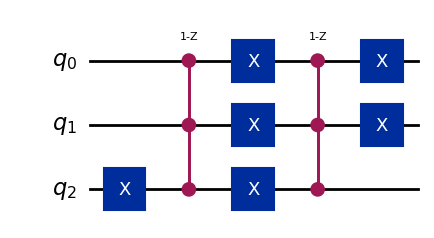

In [6]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

### GroverOperator

The built-in Qiskit `GroverOperator` takes an oracle circuit and returns a circuit that is composed of the oracle circuit itself and a circuit that amplifies the states marked by the oracle.  Here, we `decompose` the circuit to see the gates within the operator:


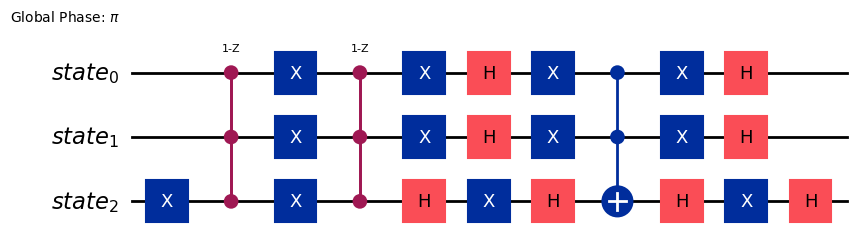

In [7]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

Repeated applications of this `grover_op` circuit amplify the marked states, making them the most probable bit-strings in the output distribution from the circuit.  There is an optimal number of such applications that is determined by the ratio of marked states to total number of possible computational states:


In [8]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

Remark: asin = arc sinus or the inverse of the sinus function. 

### Full Grover circuit

A complete Grover experiment starts with a Hadamard gate on each qubit; creating an even superposition of all computational basis states, followed the Grover operator (`grover_op`) repeated the optimal number of times.  Here we make use of the `QuantumCircuit.power(INT)` method to repeatedly apply the Grover operator.


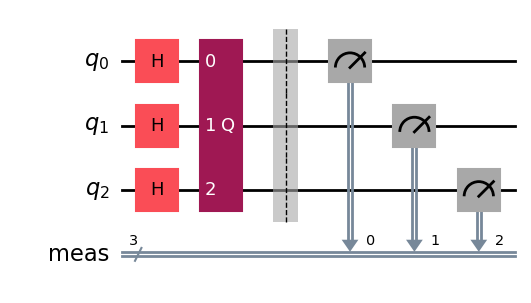

In [10]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2. Optimize problem for quantum execution


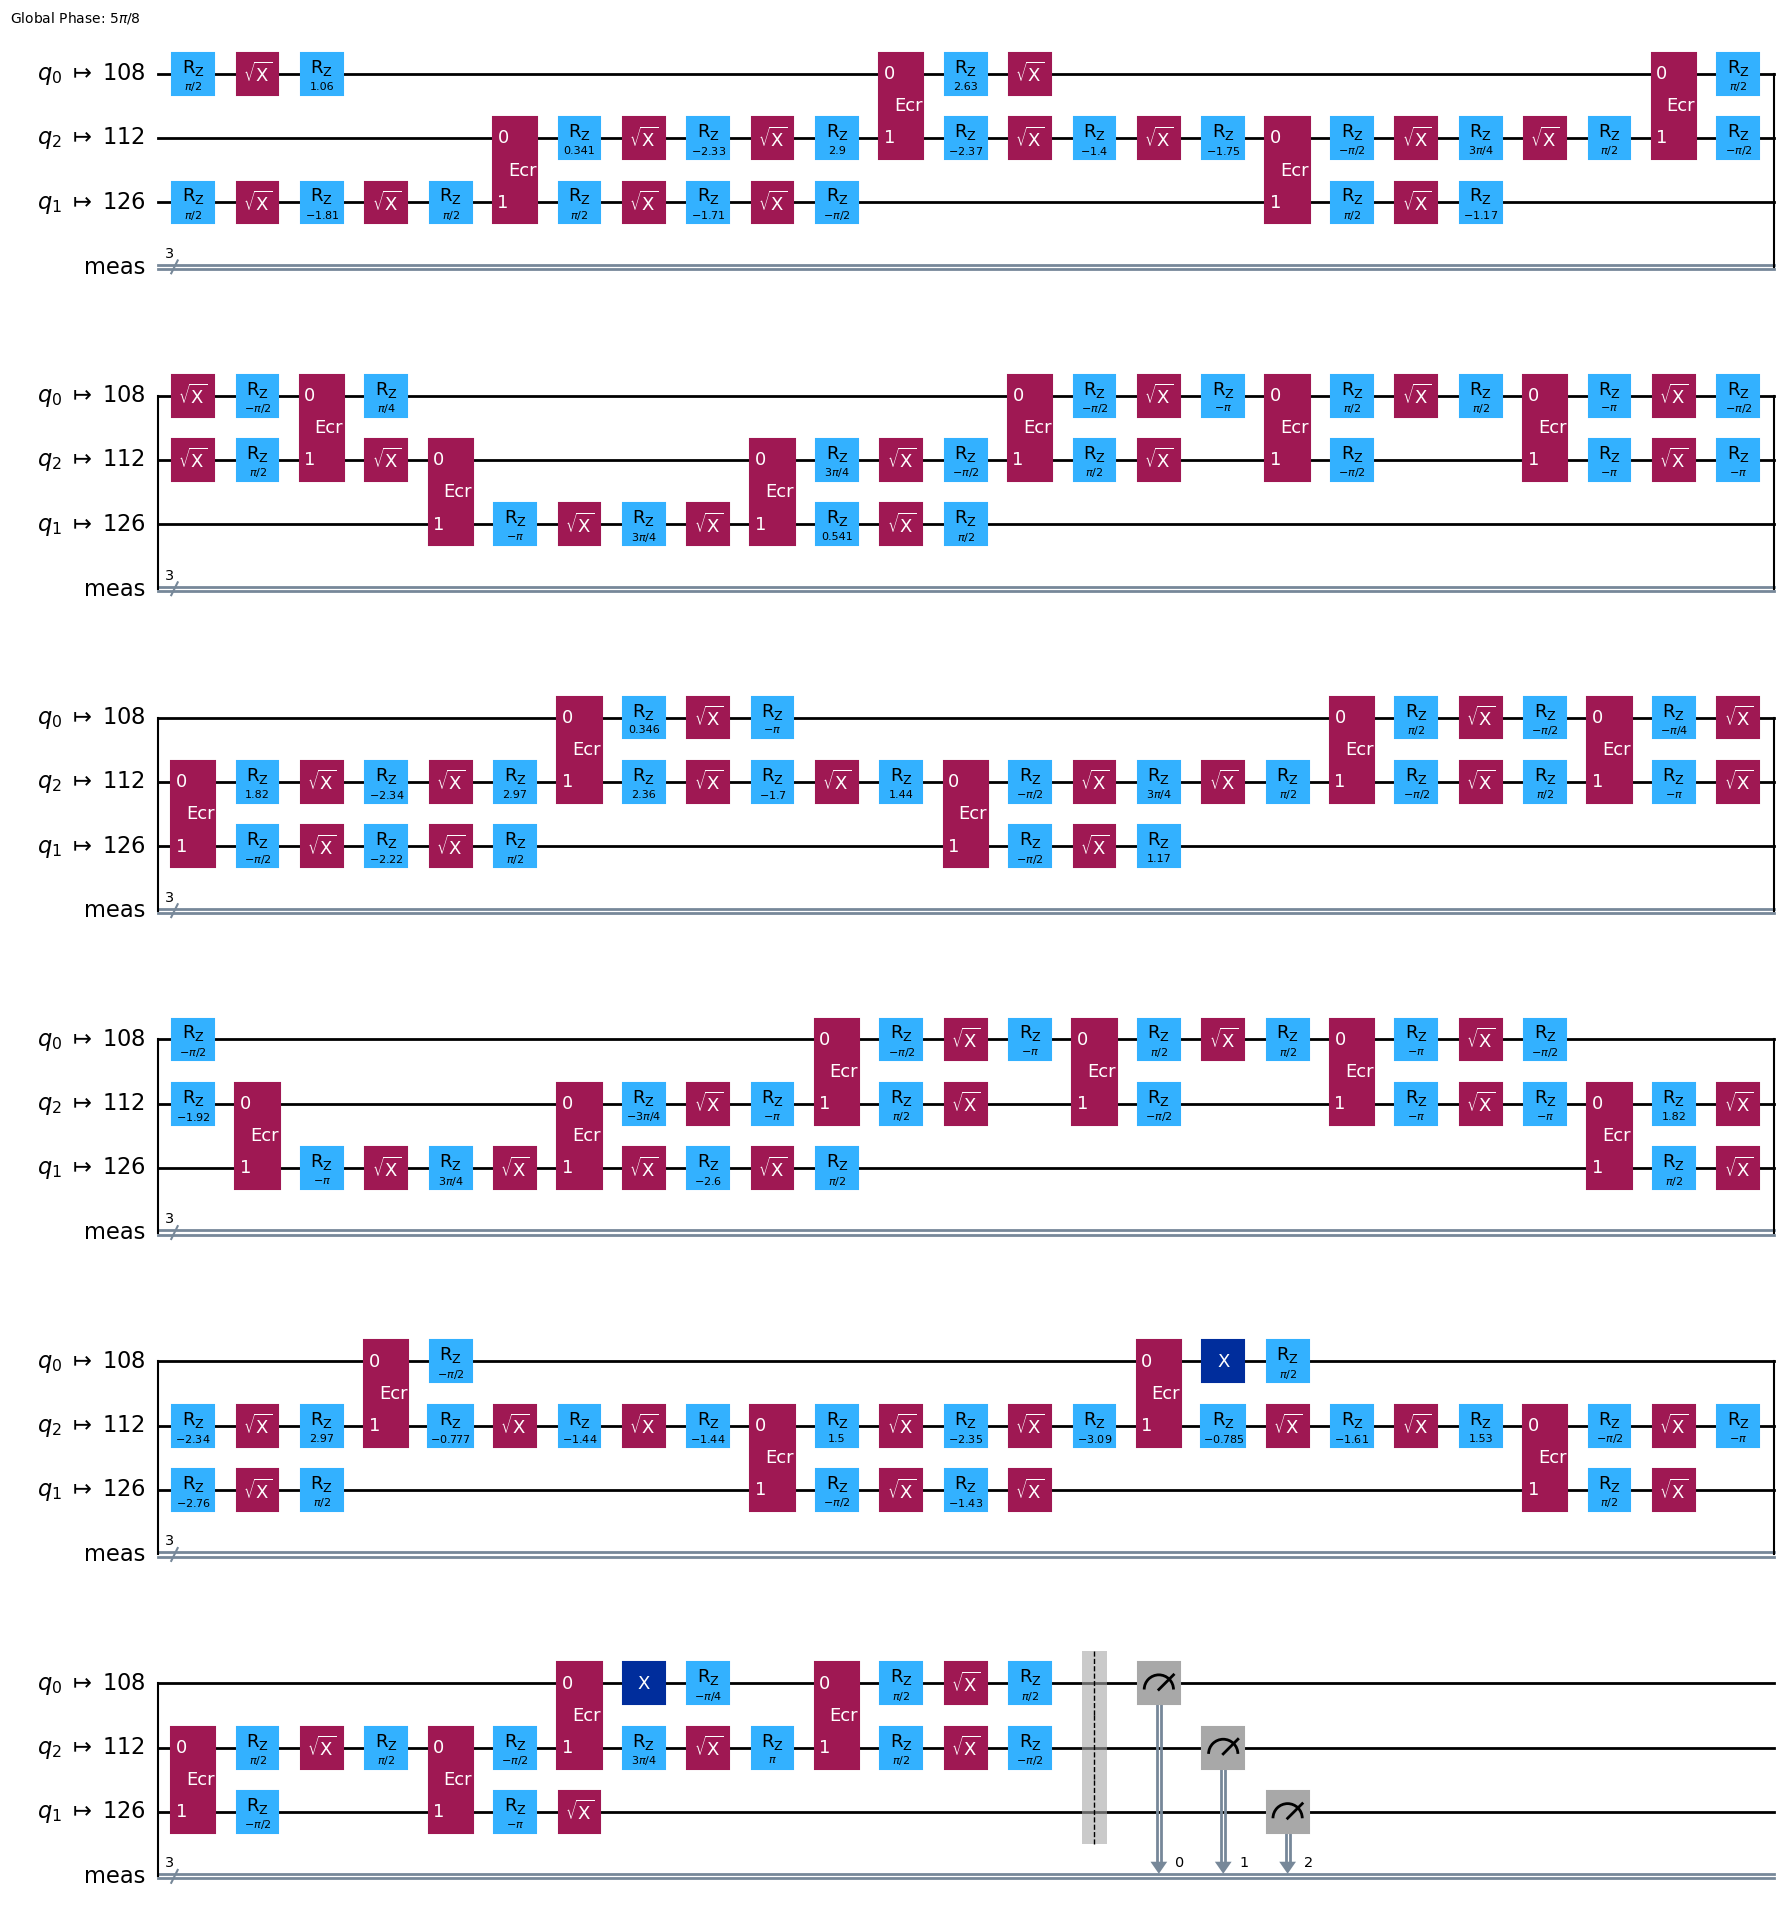

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

## Step 3. Execute using Qiskit Primitives

Amplitude amplification is a sampling problem that is suitable for execution with the [`Sampler`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2) runtime primitive.

Note that the `run()` method of [Qiskit Runtime `SamplerV2`](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.SamplerV2)  takes an iterable of `primitive unified blocs (PUBs)`. For sampler, each PUB is an iterable in the format `(circuit, parameter_values)`. However, at a minimum, it takes a list of quantum circuit(s).


In [38]:
from qiskit.primitives import Sampler

# Run the circuit on a local simulator using Sampler (local execution)
sampler = Sampler()
result = sampler.run([qc]).result()

# Extract the measurement probabilities
try:
    probabilities = result.quasi_dists[0]  # Extract the measurement probabilities
    print("Measurement Probabilities:", probabilities)
except AttributeError as e:
    print("Error extracting measurement probabilities:", e)


Measurement Probabilities: {3: 0.499999999999999, 4: 0.499999999999999}


/tmp/ipykernel_227/485909288.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


## Step 4. Post-process, return result in classical format


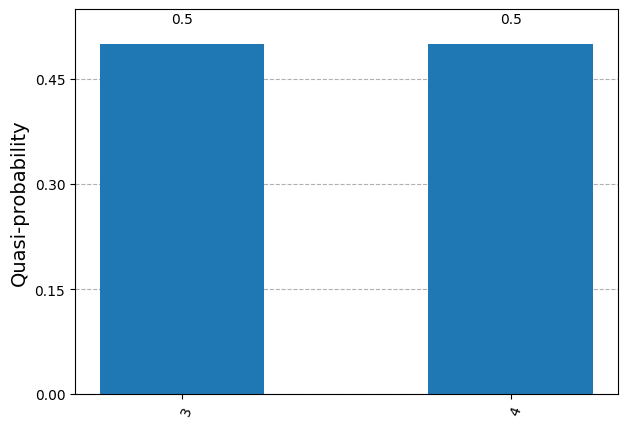

In [40]:
plot_distribution(counts)

In [41]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.34.0'

In [42]:
import qiskit

qiskit.version.get_version_info()

'1.3.1'

## **Additional Exercises**

In [60]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import QuantumCircuit, transpile

# Initialize Qiskit Runtime Service using user's IBM Quantum token
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ca510ffa26e7cab3a62660e5dfc40269bcec1b1e369333737ff46892bc37b489d6538948eac6fd55a43f7370435debcd36da4cb6a88348ed62279f1fffbd635a'
)

# Get the least busy available backend
backend = service.least_busy(operational=True, simulator=False)

# 1. Apply the algorithm on 1 new marked state with 3 Qubits on a Real Device
# This section applies Grover's algorithm on a real quantum device for a marked state "101"

# Define the marked state for Grover's algorithm
marked_states = ["101"]

# Create the Grover oracle for the marked state
oracle = grover_oracle(marked_states)  

# Initialize a quantum circuit with the same number of qubits as the Grover operator
qc = QuantumCircuit(grover_op.num_qubits)  
qc.h(range(grover_op.num_qubits))  # Create a superposition of all possible states
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)  # Apply Grover operator for the optimal number of iterations
qc.measure_all()  # Measure all qubits

# Transpile the circuit to make it compatible with the IBM backend
qc_transpiled = transpile(qc, backend=backend)

# Use the IBM backend as the mode for SamplerV2
sampler = SamplerV2(mode=backend)  # Specify the IBM backend as the execution backend

# Run the sampler and get the result
result = sampler.run([qc_transpiled]).result()  

# Extract the measurement counts from the result using _pub_results if available
try:
    if hasattr(result, '_pub_results') and hasattr(result._pub_results[0].data, 'meas'):
        dist = result._pub_results[0].data.meas.get_counts()
        print("Measurement Counts:", dist)
    else:
        print("Unable to extract measurement counts using _pub_results.")
except Exception as e:
    print("Error extracting measurement counts:", e)


Measurement Counts: {'011': 1399, '100': 1262, '010': 175, '000': 291, '101': 231, '110': 135, '111': 322, '001': 281}


In [63]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import QuantumCircuit, transpile

# Initialize Qiskit Runtime Service using user's IBM Quantum token
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ca510ffa26e7cab3a62660e5dfc40269bcec1b1e369333737ff46892bc37b489d6538948eac6fd55a43f7370435debcd36da4cb6a88348ed62279f1fffbd635a'
)

# Get the least busy available backend
backend = service.least_busy(operational=True, simulator=False)

# 2. Run the algorithm on a Fake Device with 2 new marked states
# This section applies Grover's algorithm on a fake device (simulator) with 2 marked states "001" and "111"

# Define the marked states for Grover's algorithm
marked_states = ["001", "111"]

# Create the Grover oracle for the marked states
try:
    oracle = grover_oracle(marked_states)  
except Exception as e:
    print("Error creating Grover oracle:", e)

# Check if the oracle was created successfully
if 'oracle' in locals():
    # Initialize a quantum circuit with the same number of qubits as the Grover operator
    qc = QuantumCircuit(grover_op.num_qubits)  
    qc.h(range(grover_op.num_qubits))  # Create a superposition of all possible states
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)  # Apply Grover operator for the optimal number of iterations
    qc.measure_all()  # Measure all qubits

    # Transpile the circuit to make it compatible with the IBM backend
    qc_transpiled = transpile(qc, backend=backend)

    # Use the IBM backend as the mode for SamplerV2
    sampler = SamplerV2(mode=backend)  # Specify the IBM backend as the execution backend

    # Run the sampler and get the result
    try:
        result = sampler.run([qc_transpiled]).result()  
    except Exception as e:
        print("Error running sampler:", e)

    # Extract the measurement counts from the result using _pub_results
    try:
        if hasattr(result, '_pub_results') and hasattr(result._pub_results[0].data, 'meas'):
            dist = result._pub_results[0].data.meas.get_counts()
            print("Measurement Counts:", dist)  # Display the measurement counts
        else:
            print("Unable to extract measurement counts using _pub_results.")
    except Exception as e:
        print("Error extracting measurement counts:", e)


Error creating Grover oracle: 'One or more of the arguments are empty'
Measurement Counts: {'101': 169, '011': 1498, '100': 1361, '010': 177, '001': 199, '000': 260, '111': 292, '110': 140}


In [64]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import QuantumCircuit, transpile

# Initialize Qiskit Runtime Service using user's IBM Quantum token
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ca510ffa26e7cab3a62660e5dfc40269bcec1b1e369333737ff46892bc37b489d6538948eac6fd55a43f7370435debcd36da4cb6a88348ed62279f1fffbd635a'
)

# Get the least busy available backend
backend = service.least_busy(operational=True, simulator=False)

# 3. Run the algorithm on a Simulator with the same 2 marked states
# This section runs Grover's algorithm on a Qiskit simulator for 2 marked states "001" and "111"

# Define the marked states for Grover's algorithm
marked_states = ["001", "111"]

# Create the Grover oracle for the marked states
try:
    oracle = grover_oracle(marked_states)  
except Exception as e:
    print("Error creating Grover oracle:", e)

# Check if the oracle was created successfully
if 'oracle' in locals():
    # Initialize a quantum circuit with the same number of qubits as the Grover operator
    qc = QuantumCircuit(grover_op.num_qubits)  
    qc.h(range(grover_op.num_qubits))  # Create a superposition of all possible states
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)  # Apply Grover operator for the optimal number of iterations
    qc.measure_all()  # Measure all qubits

    # Transpile the circuit to make it compatible with the IBM backend
    qc_transpiled = transpile(qc, backend=backend)

    # Use the IBM backend as the mode for SamplerV2
    sampler = SamplerV2(mode=backend)  # Specify the IBM backend as the execution backend

    # Run the sampler and get the result
    try:
        result = sampler.run([qc_transpiled]).result()  
    except Exception as e:
        print("Error running sampler:", e)

    # Extract the measurement counts from the result using _pub_results
    try:
        if hasattr(result, '_pub_results') and hasattr(result._pub_results[0].data, 'meas'):
            dist = result._pub_results[0].data.meas.get_counts()
            print("Measurement Counts:", dist)  # Display the measurement counts
        else:
            print("Unable to extract measurement counts using _pub_results.")
    except Exception as e:
        print("Error extracting measurement counts:", e)


Error creating Grover oracle: 'One or more of the arguments are empty'
Measurement Counts: {'100': 1244, '110': 209, '011': 987, '111': 405, '000': 318, '101': 235, '010': 490, '001': 208}


In [66]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit import QuantumCircuit, transpile

# Initialize Qiskit Runtime Service using user's IBM Quantum token
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='ca510ffa26e7cab3a62660e5dfc40269bcec1b1e369333737ff46892bc37b489d6538948eac6fd55a43f7370435debcd36da4cb6a88348ed62279f1fffbd635a'
)

# Get the least busy available backend
backend = service.least_busy(operational=True, simulator=False)

# 4. Apply the algorithm on 1 new marked state with 4 Qubits on a Real Device
# This section applies Grover's algorithm on a real device for a marked state "1001"

# Define the marked state for Grover's algorithm
marked_states = ["1001"]

# Create the Grover oracle for the marked state
try:
    oracle = grover_oracle(marked_states)  
except Exception as e:
    print("Error creating Grover oracle:", e)

# Check if the oracle was created successfully
if 'oracle' in locals():
    # Initialize a quantum circuit with the same number of qubits as the Grover operator
    qc = QuantumCircuit(grover_op.num_qubits)  
    qc.h(range(grover_op.num_qubits))  # Create a superposition of all possible states
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True)  # Apply Grover operator for the optimal number of iterations
    qc.measure_all()  # Measure all qubits

    # Transpile the circuit to make it compatible with the IBM backend
    qc_transpiled = transpile(qc, backend=backend)

    # Use the IBM backend as the mode for SamplerV2
    sampler = SamplerV2(mode=backend)  # Specify the IBM backend as the execution backend

    # Run the sampler and get the result
    try:
        result = sampler.run([qc_transpiled]).result()  
    except Exception as e:
        print("Error running sampler:", e)

    # Extract the measurement counts from the result using _pub_results
    try:
        if hasattr(result, '_pub_results') and hasattr(result._pub_results[0].data, 'meas'):
            dist = result._pub_results[0].data.meas.get_counts()
            print("Measurement Counts:", dist)  # Display the measurement counts
        else:
            print("Unable to extract measurement counts using _pub_results.")
    except Exception as e:
        print("Error extracting measurement counts:", e)


Measurement Counts: {'010': 439, '001': 227, '111': 472, '000': 381, '100': 1174, '101': 253, '011': 915, '110': 235}


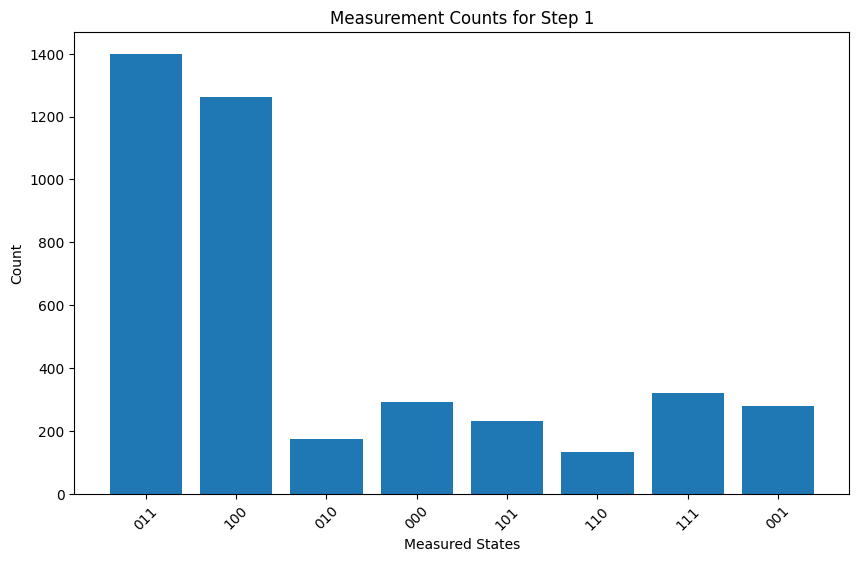

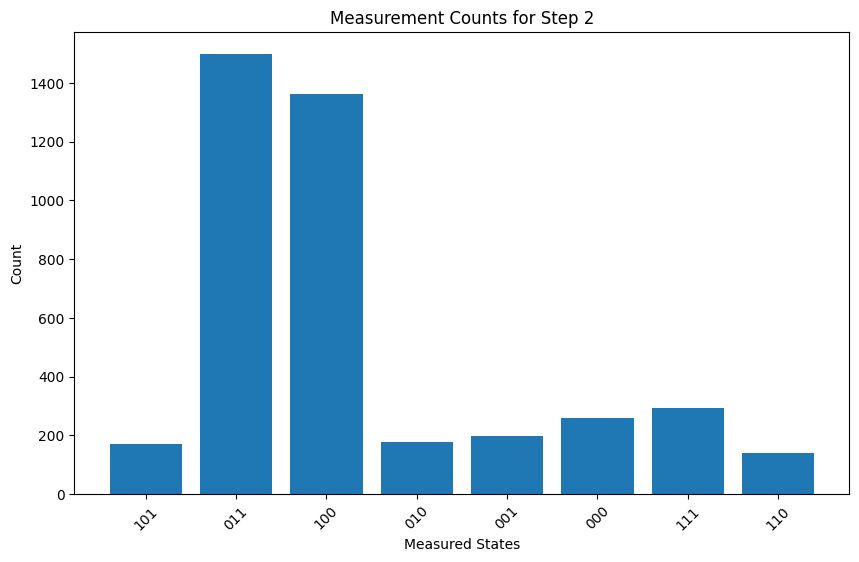

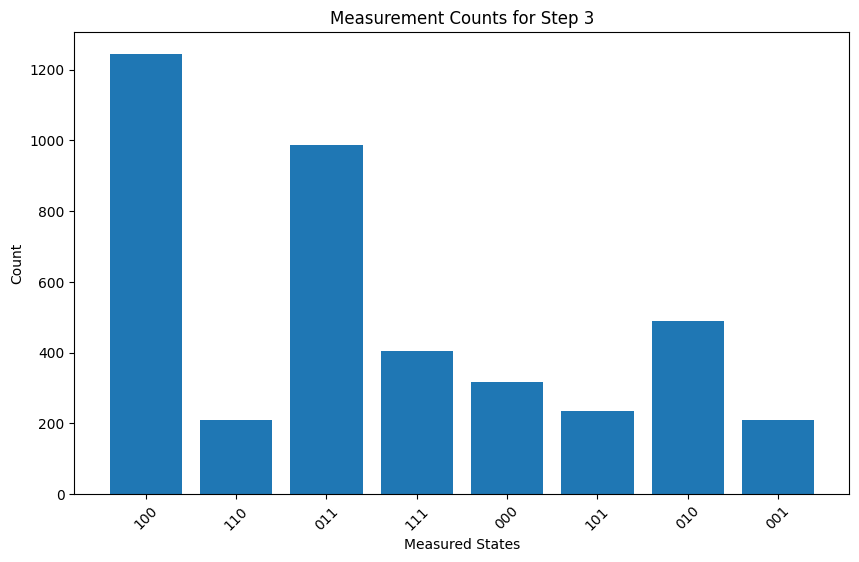

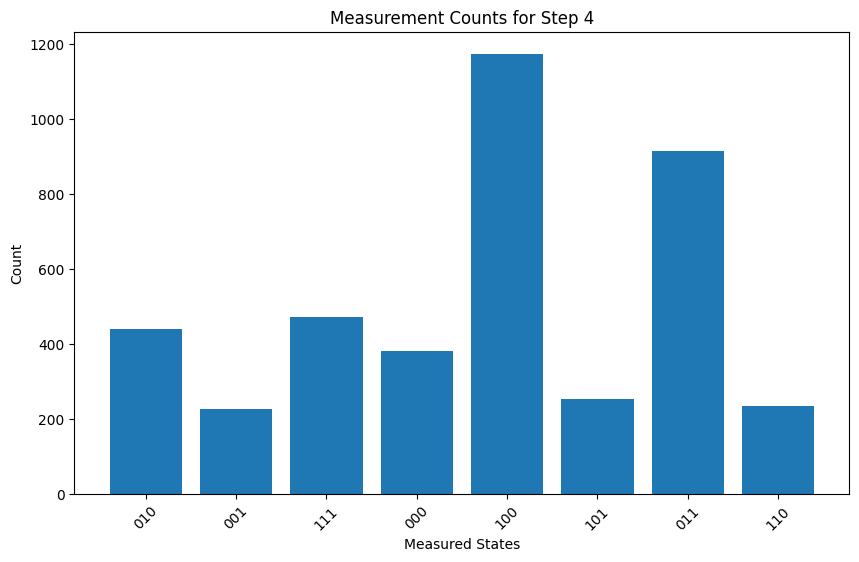

In [67]:
import matplotlib.pyplot as plt

# 5. Visualization to check the consistency of results across all steps

# Sample measurement counts from all steps
measurement_counts = {
    'Step 1': {'011': 1399, '100': 1262, '010': 175, '000': 291, '101': 231, '110': 135, '111': 322, '001': 281},
    'Step 2': {'101': 169, '011': 1498, '100': 1361, '010': 177, '001': 199, '000': 260, '111': 292, '110': 140},
    'Step 3': {'100': 1244, '110': 209, '011': 987, '111': 405, '000': 318, '101': 235, '010': 490, '001': 208},
    'Step 4': {'010': 439, '001': 227, '111': 472, '000': 381, '100': 1174, '101': 253, '011': 915, '110': 235}
}

# Visualization function to display counts across different steps
def visualize_consistency(measurement_counts):
    for step, counts in measurement_counts.items():
        plt.figure(figsize=(10, 6))
        plt.bar(counts.keys(), counts.values())
        plt.title(f"Measurement Counts for {step}")
        plt.xlabel("Measured States")
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.show()

# Call the visualization function to display all steps
visualize_consistency(measurement_counts)
